## Tarea de acción 4
### Modelo Lineal - Grupo 5           
<img src="https://upload.wikimedia.org/wikipedia/commons/f/ff/Logo-Universidad-Andres-Bello-2013-Nuevo.jpg" width="150" align="right">

Integrantes del grupo:

1.- Jorge Villablanca

2.- Cindi Elizondo

3.- Juan Carlos Mérida

Para el desarrollo de esta tarea es necesario estudiar el material correspondiente a este módulo,
junto con las clases sincrónicas.

En esta actividad, nos sumergiremos en el emocionante mundo del aprendizaje automático
aplicado a la agricultura. ¿Alguna vez te has preguntado cómo las máquinas pueden ayudarnos
a predecir calidad de las frutas? Bueno. Hoy exploraremos precisamente esto.

Tendremos a disposición una base de datos que contiene una variedad de información sobre
manzanas: su madurez, peso, tamaño, dulzor y otras. Además, contamos con un dato adicional
para cada manzana, una etiqueta que nos indica la calidad general de esta (Good or Bad).

El objetivo de esta actividad es entrenar una máquina de soporte vectorial para predicción de
calidad de manzanas.

Además, se deberá entrenar un modelo de regresión lineal múltiple para estimar el grado de
dulzor de la manzana.

La base de datos viene en formato csv (apple_quality.csv). Los campos disponibles son:

• A_id: Identificación único de cada fruta

• Size: Tamaño de la fruta

• Weight: Peso de la fruta

• Sweetness: Dulzor de la fruta

• Crunchiness: Textura que indica el carácter crujiente de la fruta

• Juiciness: Grado de jugosidad de la fruta

• Ripeness: Grado de madurez de la fruta

• Acidity: Grado de acidez de la fruta

• Quality: Calidad general de la fruta

### Actividades

#### 1a. Cargar la base de datos apple_quality.csv y realizar proceso de limpieza, identificando valores outliers, ausentes y valores con error.

#### Primero cargamos las librerías necesarias:

In [1]:
# Manipulación y análisis de datos:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Importamos modelo y sus métricas de evaluación:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import r2_score, accuracy_score, classification_report
from sklearn.metrics import mean_absolute_error, mean_squared_error
import scipy.stats as stats

# Para graficar
import matplotlib.pyplot as plt
import seaborn as sns
import math

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Cargar los datos desde un archivo csv en un DataFrame de pandas:
df = pd.read_csv("apple_quality.csv")
df.head()

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,0.0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590483,good
1,1.0,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809367,good
2,2.0,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636473,bad
3,3.0,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723217,good
4,4.0,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984036,good


In [3]:
# Obtener la cantidad de filas y columnas del DataFrame
filas, columnas = df.shape

# Imprimir el número de filas y columnas del DataFrame
print(f"Número de filas: {filas}")
print(f"Número de columnas: {columnas}")

Número de filas: 4001
Número de columnas: 9


#### Analizamos la columna A_id para verificar si sus valores son correlativos. Si es así, consideraremos eliminarla, ya que su inclusión no aportaría valor al entrenamiento del modelo.

In [4]:
# Calcular las diferencias sucesivas en 'A_id'
diferencias = df['A_id'].diff()

# Contar la cantidad de veces que la diferencia es exactamente 1
correlativos = (diferencias == 1).sum()

# Calcular el porcentaje de valores correlativos
porcentaje_correlativos = correlativos / (len(diferencias) - 1) * 100  # -1 porque la primera diferencia es NaN

# Mostrar el resultado
print(f"Porcentaje de valores correlativos en 'A_id': {porcentaje_correlativos:.2f}%")

# Decidir si la columna es relevante
if porcentaje_correlativos > 95:  # Umbral: si más del 95% es correlativo
    print("La columna 'A_id' es mayormente correlativa y podría no ser relevante para el modelo.")
else:
    print("La columna 'A_id' tiene suficientes variaciones y podría ser relevante para el modelo.")

Porcentaje de valores correlativos en 'A_id': 99.98%
La columna 'A_id' es mayormente correlativa y podría no ser relevante para el modelo.


Dado que mas del 95% de los valores de A_id son correlativos, para efectos del entrenamiento del modelo es mejor eliminar la columna para disminuir el ruido existente.

In [5]:
# Eliminar la columna 'A_id'
df.drop(columns=['A_id'], inplace=True)

df.head()

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590483,good
1,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809367,good
2,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636473,bad
3,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723217,good
4,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984036,good


#### Detectamos Outliers:

In [6]:
# Definir una función para detectar outliers y también almacenar los límites del IQR
def detect_outliers_iqr_with_limits(df):
    outliers_info = {}
    limits = {}
    
    for column in df.select_dtypes(include=['float64', 'int64']).columns:  # Solo para columnas numéricas
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        # Calcular los límites superior e inferior para detectar outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Contar outliers y almacenar los límites
        outlier_count = ((df[column] < lower_bound) | (df[column] > upper_bound)).sum()
        limits[column] = (lower_bound, upper_bound)
        outliers_info[column] = outlier_count
    
    return outliers_info, limits

In [7]:
# Detectar outliers y obtener los límites del IQR
outliers_info, iqr_limits = detect_outliers_iqr_with_limits(df)

# Mostrar la cantidad de outliers por cada columna
for column, count in outliers_info.items():
    print(f"{column}: {count} outliers")

# Mostrar el total de outliers encontrados
total_outliers = sum(outliers_info.values())
print(f"Total de outliers encontrados: {total_outliers}")

Size: 22 outliers
Weight: 54 outliers
Sweetness: 32 outliers
Crunchiness: 47 outliers
Juiciness: 32 outliers
Ripeness: 24 outliers
Total de outliers encontrados: 211


#### Eliminamos Outliers:

In [8]:
# Eliminación de valores ausentes con mediana para numéricos y moda para categóricos
for columna in df.columns:
    if df[columna].isnull().sum() > 0:
        if df[columna].dtype in ['float64', 'int64']:
            df[columna].fillna(df[columna].median(), inplace=True)
        else:
            df[columna].fillna(df[columna].mode()[0], inplace=True)

# Eliminación de outliers usando el rango intercuartil (IQR)
for columna in df.select_dtypes(include=np.number).columns:
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    df = df[(df[columna] >= (Q1 - 1.5 * IQR)) & (df[columna] <= (Q3 + 1.5 * IQR))]

# Eliminación de valores fuera del rango esperado en la columna 'calidad'
if 'calidad' in df.columns:
    df = df[(df['calidad'] >= 0) & (df['calidad'] <= 10)]

In [9]:
# Obtener la cantidad de filas y columnas del DataFrame
filas, columnas = df.shape

# Imprimir el número de filas y columnas del DataFrame
print(f"Número de filas: {filas}")
print(f"Número de columnas: {columnas}")

Número de filas: 3804
Número de columnas: 8


#### Identificamos valores ausentes:

In [10]:
# Calcular el porcentaje de valores ausentes para cada columna
percent_missing = df.isnull().sum() * 100 / len(df)

# Crear un DataFrame que solo muestre los porcentajes de valores ausentes de manera ordenada
missing_data = pd.DataFrame(percent_missing, columns=['Percent_Missing'])

# Mostrar el DataFrame
missing_data

,Percent_Missing
Size,0.0
Weight,0.0
Sweetness,0.0
Crunchiness,0.0
Juiciness,0.0
Ripeness,0.0
Acidity,0.0
Quality,0.0


No tenemos valores ausentes en nuestra data.

#### Identificamos valores duplicados:

In [11]:
# Identificar y contar duplicados
duplicados = df[df.duplicated()]
print("Número de duplicados:", duplicados.shape[0])

Número de duplicados: 0


No tenemos valores duplicados.

#### Verificamos tipos de datos:

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3804 entries, 1 to 4000
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Size         3804 non-null   float64
 1   Weight       3804 non-null   float64
 2   Sweetness    3804 non-null   float64
 3   Crunchiness  3804 non-null   float64
 4   Juiciness    3804 non-null   float64
 5   Ripeness     3804 non-null   float64
 6   Acidity      3804 non-null   object 
 7   Quality      3804 non-null   object 
dtypes: float64(6), object(2)
memory usage: 267.5+ KB


In [13]:
df.head()

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
1,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809367,good
2,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636473,bad
3,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723217,good
4,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984036,good
5,-3.425400,-1.409082,-1.913511,-0.555775,-3.853071,1.914616,-2.981523169,bad


Podemos apreciar que "Acidity" esta como tipo de dato "Object", cuando realmente debería ser de tipo float, probablemente el problema se origina debido a alguna fila con caracteres incorrectos, asi que revisaremos la columna:

#### Buscamos errores en Acidity:

In [14]:
# Filtrar los valores en 'Acidity' que no son numéricos, permitiendo números negativos y decimales
errores_acidity = df[~df['Acidity'].apply(lambda x: str(x).replace('-', '', 1).replace('.', '', 1).isdigit())]

# Mostrar el número de valores problemáticos en 'Acidity' y los valores en sí
print(f"Valores problemáticos en 'Acidity': {errores_acidity.shape[0]}")
print(errores_acidity[['Acidity']])

Valores problemáticos en 'Acidity': 1
                                Acidity
4000  Created_by_Nidula_Elgiriyewithana


In [15]:
# Eliminar los registros problemáticos en 'Acidity' usando el índice de errores_acidity
df = df.drop(errores_acidity.index).reset_index(drop=True)

# Verificar cuántos valores problemáticos quedan en 'Acidity' después de la eliminación
errores_restantes = df[~df['Acidity'].apply(lambda x: str(x).replace('-', '', 1).replace('.', '', 1).isdigit())]
print(f"Número de filas problemáticas restantes en 'Acidity': {errores_restantes.shape[0]}")

Número de filas problemáticas restantes en 'Acidity': 0


Hemos eliminado correctamente la fila problemática.

#### Transformamos Acidity a float:

In [16]:
# Convertir la columna 'Acidity' a tipo float
df['Acidity'] = df['Acidity'].astype(float)

# Verificar la conversión
df.dtypes

Size           float64
Weight         float64
Sweetness      float64
Crunchiness    float64
Juiciness      float64
Ripeness       float64
Acidity        float64
Quality         object
dtype: object

#### Contamos la cantidad de valores únicos de cada columna:

In [17]:
# Contar la cantidad de valores distintos en cada columna
valores_distintos = df.nunique()

# Mostrar los resultados
print("Cantidad de valores distintos en cada columna:")
print(valores_distintos)

Cantidad de valores distintos en cada columna:
Size           3803
Weight         3803
Sweetness      3803
Crunchiness    3803
Juiciness      3803
Ripeness       3803
Acidity        3803
Quality           2
dtype: int64


#### 1b.- Realizar un análisis exploratorio descriptivo de los datos analizando la relación entre las variables explicativas con la variable dependiente, use representaciones visuales adecuadas, y comente cada gráfico y concluya. (5 pts.)

#### Revisamos métricas de las variables:

In [18]:
df.describe()

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity
count,3803.000000,3803.000000,3803.000000,3803.000000,3803.000000,3803.000000,3803.000000
mean,-0.512107,-0.987696,-0.477286,0.983250,0.501966,0.527346,0.067108
std,1.855284,1.499626,1.872601,1.299762,1.852821,1.805351,2.084345
min,-5.692093,-5.058679,-5.548641,-2.620954,-4.688478,-4.471210,-6.955460
25%,-1.800751,-1.970026,-1.724301,0.093946,-0.792918,-0.712315,-1.373326
50%,-0.517699,-0.979619,-0.503052,0.994175,0.514115,0.526588,0.017096
75%,0.771448,0.010163,0.783380,1.872825,1.792787,1.771178,1.484951
max,4.524772,3.081538,4.606386,4.591936,5.598023,5.484760,7.193374


Las variables independientes1 (Size, Weight, Sweetness, Crunchiness, Juiciness, Ripeness, y Acidity) están centradas cerca de cero, con distribuciones amplias pero sin valores extremos, lo que refleja una variabilidad significativa entre las observaciones. Las variables presentan una dispersión en ambos lados del cero, lo cual sugiere que podrían estar distribuidas simétricamente. En el siguiente paso, un análisis visual de la relación entre estas variables y la variable dependiente (Quality) permitirá comprender mejor su posible influencia y patrones relevantes para el modelo.

#### Elaboramos un heatmap con nuestras variables:

In [19]:
df.head()

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809,good
1,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636,bad
2,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723,good
3,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984,good
4,-3.425400,-1.409082,-1.913511,-0.555775,-3.853071,1.914616,-2.981523,bad


In [20]:
# Mantenemos solo las variables numéricas para la creación del headmap:
vcontinuas = df.drop(columns='Quality').columns
mcorr = df.loc[:, vcontinuas].corr(method='pearson') # Definimos Pearson como el método de calcular la correlación

mcorr

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity
Size,1.000000,-0.147815,-0.333978,0.169930,-0.023081,-0.153158,0.173630
Weight,-0.147815,1.000000,-0.138483,-0.098001,-0.084672,-0.231423,0.035600
Sweetness,-0.333978,-0.138483,1.000000,-0.025540,0.087505,-0.276258,0.074914
Crunchiness,0.169930,-0.098001,-0.025540,1.000000,-0.231338,-0.190146,0.073495
Juiciness,-0.023081,-0.084672,0.087505,-0.231338,1.000000,-0.107891,0.247280
Ripeness,-0.153158,-0.231423,-0.276258,-0.190146,-0.107891,1.000000,-0.203395
Acidity,0.173630,0.035600,0.074914,0.073495,0.247280,-0.203395,1.000000


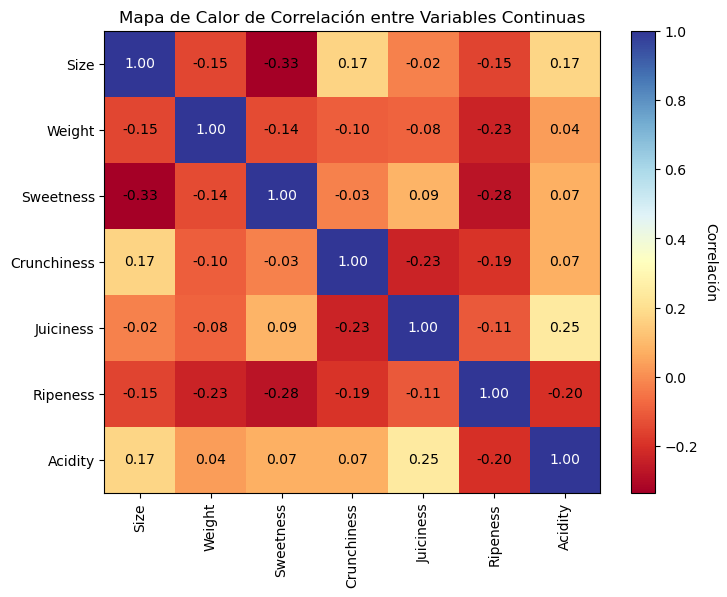

Lista de correlaciones entre variables:


,Variable 1,Variable 2,Correlación
0,Juiciness,Acidity,0.247280
1,Size,Acidity,0.173630
2,Size,Crunchiness,0.169930
3,Sweetness,Juiciness,0.087505
4,Sweetness,Acidity,0.074914
5,Crunchiness,Acidity,0.073495
6,Weight,Acidity,0.035600
7,Size,Juiciness,-0.023081
8,Sweetness,Crunchiness,-0.025540
9,Weight,Juiciness,-0.084672


In [21]:
# Creación del mapa de calor
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(mcorr, cmap='RdYlBu', aspect='auto')

# Barra de color
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Correlación", rotation=-90, va="bottom")

# Etiquetas en los ejes
ax.set_xticks(np.arange(len(vcontinuas)))
ax.set_yticks(np.arange(len(vcontinuas)))
ax.set_xticklabels(vcontinuas, rotation=90)
ax.set_yticklabels(vcontinuas)

# Mostrar valores de correlación en cada celda
for i in range(len(vcontinuas)):
    for j in range(len(vcontinuas)):
        corr_value = mcorr.iloc[i, j]
        ax.text(i, j, f"{corr_value:.2f}", ha='center', va='center', color="black" if abs(corr_value) < 0.5 else "white")

ax.set_title("Mapa de Calor de Correlación entre Variables Continuas")
plt.show()

# Crear una lista de combinaciones de variables y sus valores de correlación
correlaciones = []

for i in range(len(vcontinuas)):
    for j in range(i + 1, len(vcontinuas)):  # Solo combinaciones únicas
        var1 = vcontinuas[i]
        var2 = vcontinuas[j]
        corr_value = mcorr.loc[var1, var2]
        correlaciones.append((var1, var2, corr_value))

# Convertir la lista a un DataFrame para facilitar la lectura y ordenarla
correlaciones_df = pd.DataFrame(correlaciones, columns=['Variable 1', 'Variable 2', 'Correlación'])
correlaciones_df = correlaciones_df.sort_values(by='Correlación', ascending=False).reset_index(drop=True)

# Mostrar la lista ordenada
print("Lista de correlaciones entre variables:")
correlaciones_df

#### Modificamos el heatmap:

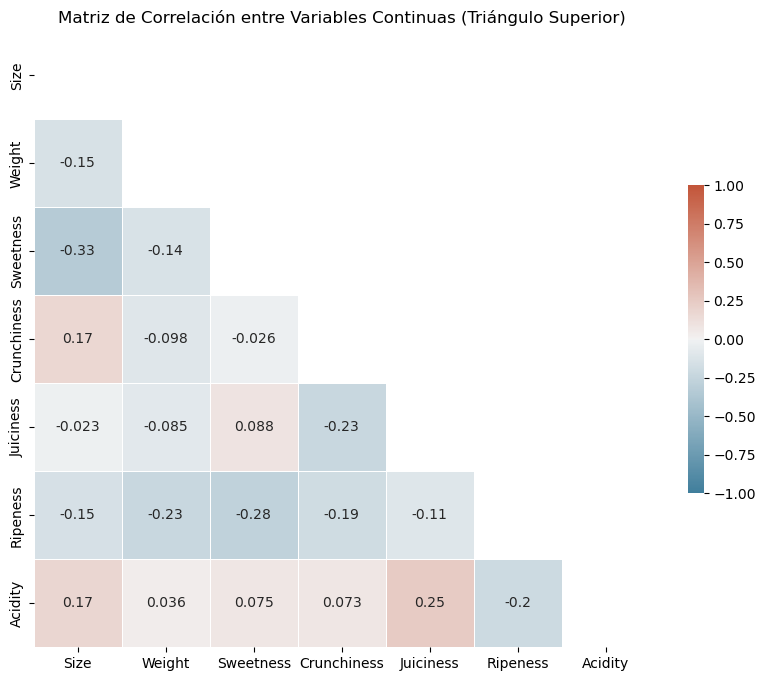

In [22]:
# Generar una máscara para el triángulo superior
mask = np.triu(np.ones_like(mcorr, dtype=bool))

# Crear un colormap divergente personalizado
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Dibujar el mapa de calor con la máscara y relación de aspecto adecuada
plt.figure(figsize=(10, 8))
sns.heatmap(mcorr, mask=mask, cmap=cmap, vmax=1.0, vmin=-1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.title("Matriz de Correlación entre Variables Continuas (Triángulo Superior)")
plt.show()

El análisis de correlación muestra que, en general, las variables tienen correlaciones bajas entre sí, lo cual sugiere que no hay una fuerte relación lineal entre la mayoría de ellas. La correlación más alta es entre Juiciness y Acidity (0,25), aunque sigue siendo moderada y no indica una fuerte interdependencia.

Al observar las relaciones negativas, encontramos que Size y Sweetness tienen la correlación negativa más pronunciada (-0,33), lo cual podría indicar que los tamaños más grandes tienden a ser menos dulces, aunque esta relación tampoco es lo suficientemente fuerte como para considerarse determinante. Otros pares, como Weight y Ripeness, también muestran correlaciones negativas menores (-0,23), sugiriendo una ligera tendencia en la que frutas menos maduras pueden ser algo más pesadas.

En general, estas correlaciones bajas sugieren que las variables explicativas son en su mayoría independientes entre sí, lo cual es positivo para el modelo, ya que implica que cada variable puede aportar información única sin redundancia significativa. Este análisis permite concluir que todas las variables tienen el potencial de contribuir al modelo sin requerir una eliminación basada en colinealidad excesiva.

#### Análisis de distribución de las variables:

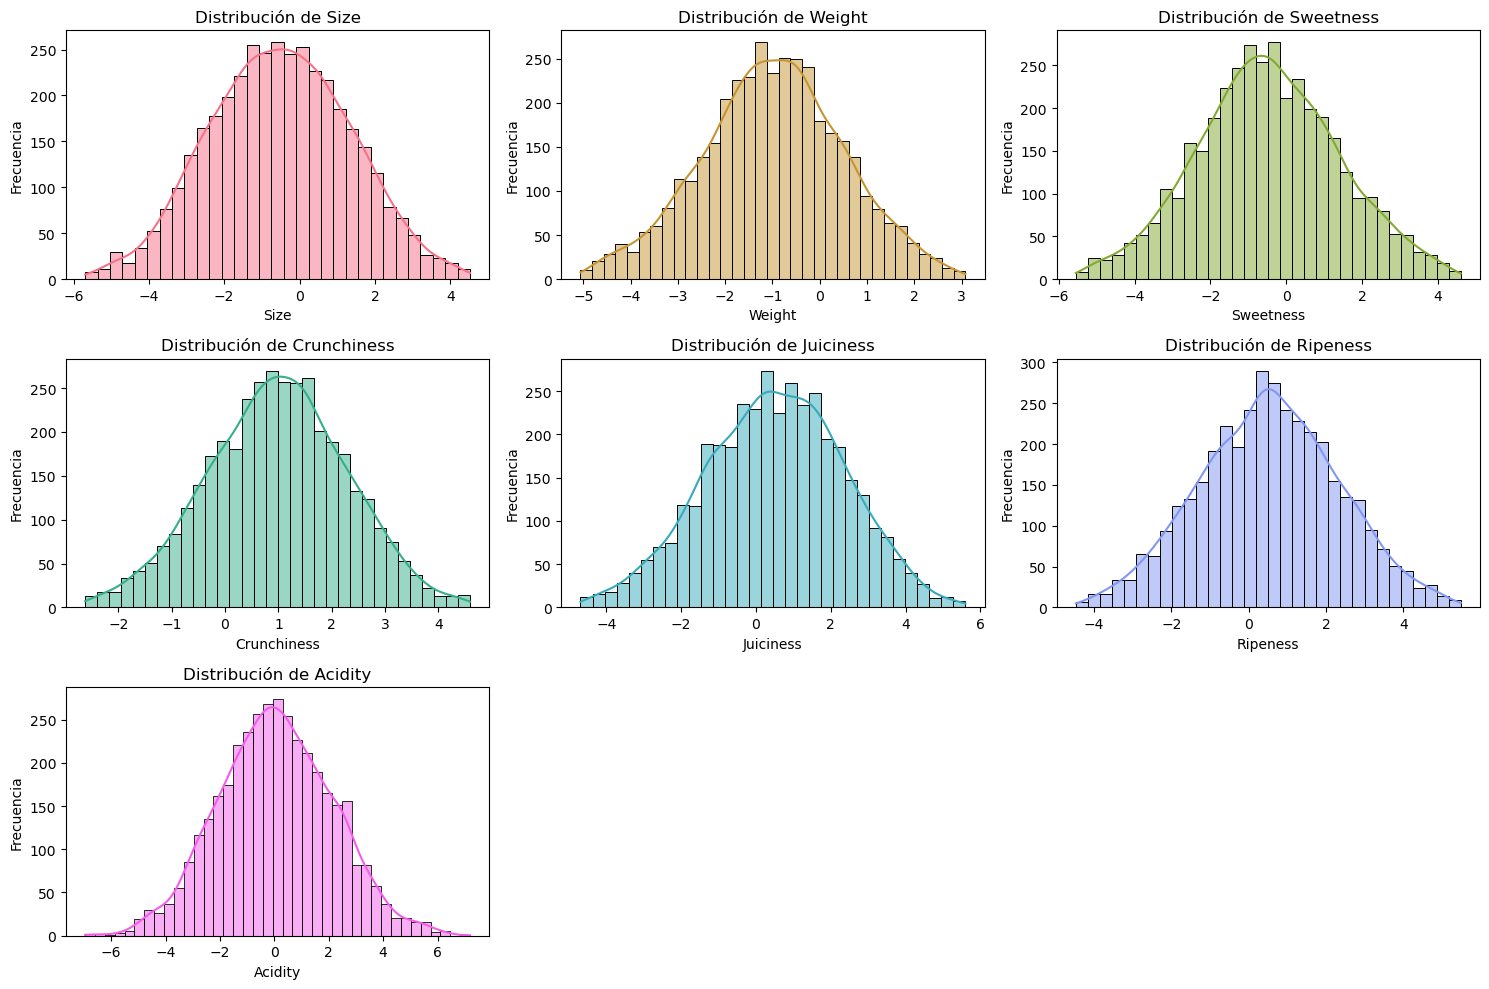

In [23]:
# Lista de variables continuas (sin 'Quality')
vcontinuas = df.drop(columns='Quality').columns

# Paleta de colores para los gráficos
colors = sns.color_palette("husl", len(vcontinuas))  # Paleta "husl" para variedad de colores

# Configuración del tamaño del gráfico
plt.figure(figsize=(15, 10))

# Crear un subplot para cada variable, asignando un color distinto a cada uno
for i, (var, color) in enumerate(zip(vcontinuas, colors), 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[var], kde=True, color=color)  # Asignar color específico a cada gráfico
    plt.title(f'Distribución de {var}')
    plt.xlabel(var)
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

Las distribuciones mostradas para cada variable (Size, Weight, Sweetness, Crunchiness, Juiciness, Ripeness, y Acidity) presentan una forma simétrica que se asemeja a una distribución normal. Este patrón es interesante, ya que en datos reales no siempre se observa este tipo de distribución tan claramente.

La eliminación de outliers probablemente contribuyó a esta apariencia normal. Al remover valores extremos, las distribuciones se "ajustan" alrededor de la media, lo cual tiende a realzar una forma más simétrica y concentrada en el centro. Este proceso de limpieza ayuda a reducir sesgos causados por valores anómalos y permite observar una estructura más estable de los datos.

La normalidad en las variables es ventajosa para el análisis, especialmente en técnicas estadísticas y de modelado que asumen esta propiedad. Además, la normalidad facilita el uso de métodos paramétricos y permite una interpretación más consistente de las métricas centrales (media y desviación estándar) para cada variable. Este tipo de distribución también sugiere que los datos tienen variaciones naturales sin tendencias extremas, lo que es ideal para un análisis predictivo confiable.

#### Complementamos con gráficos verticales:

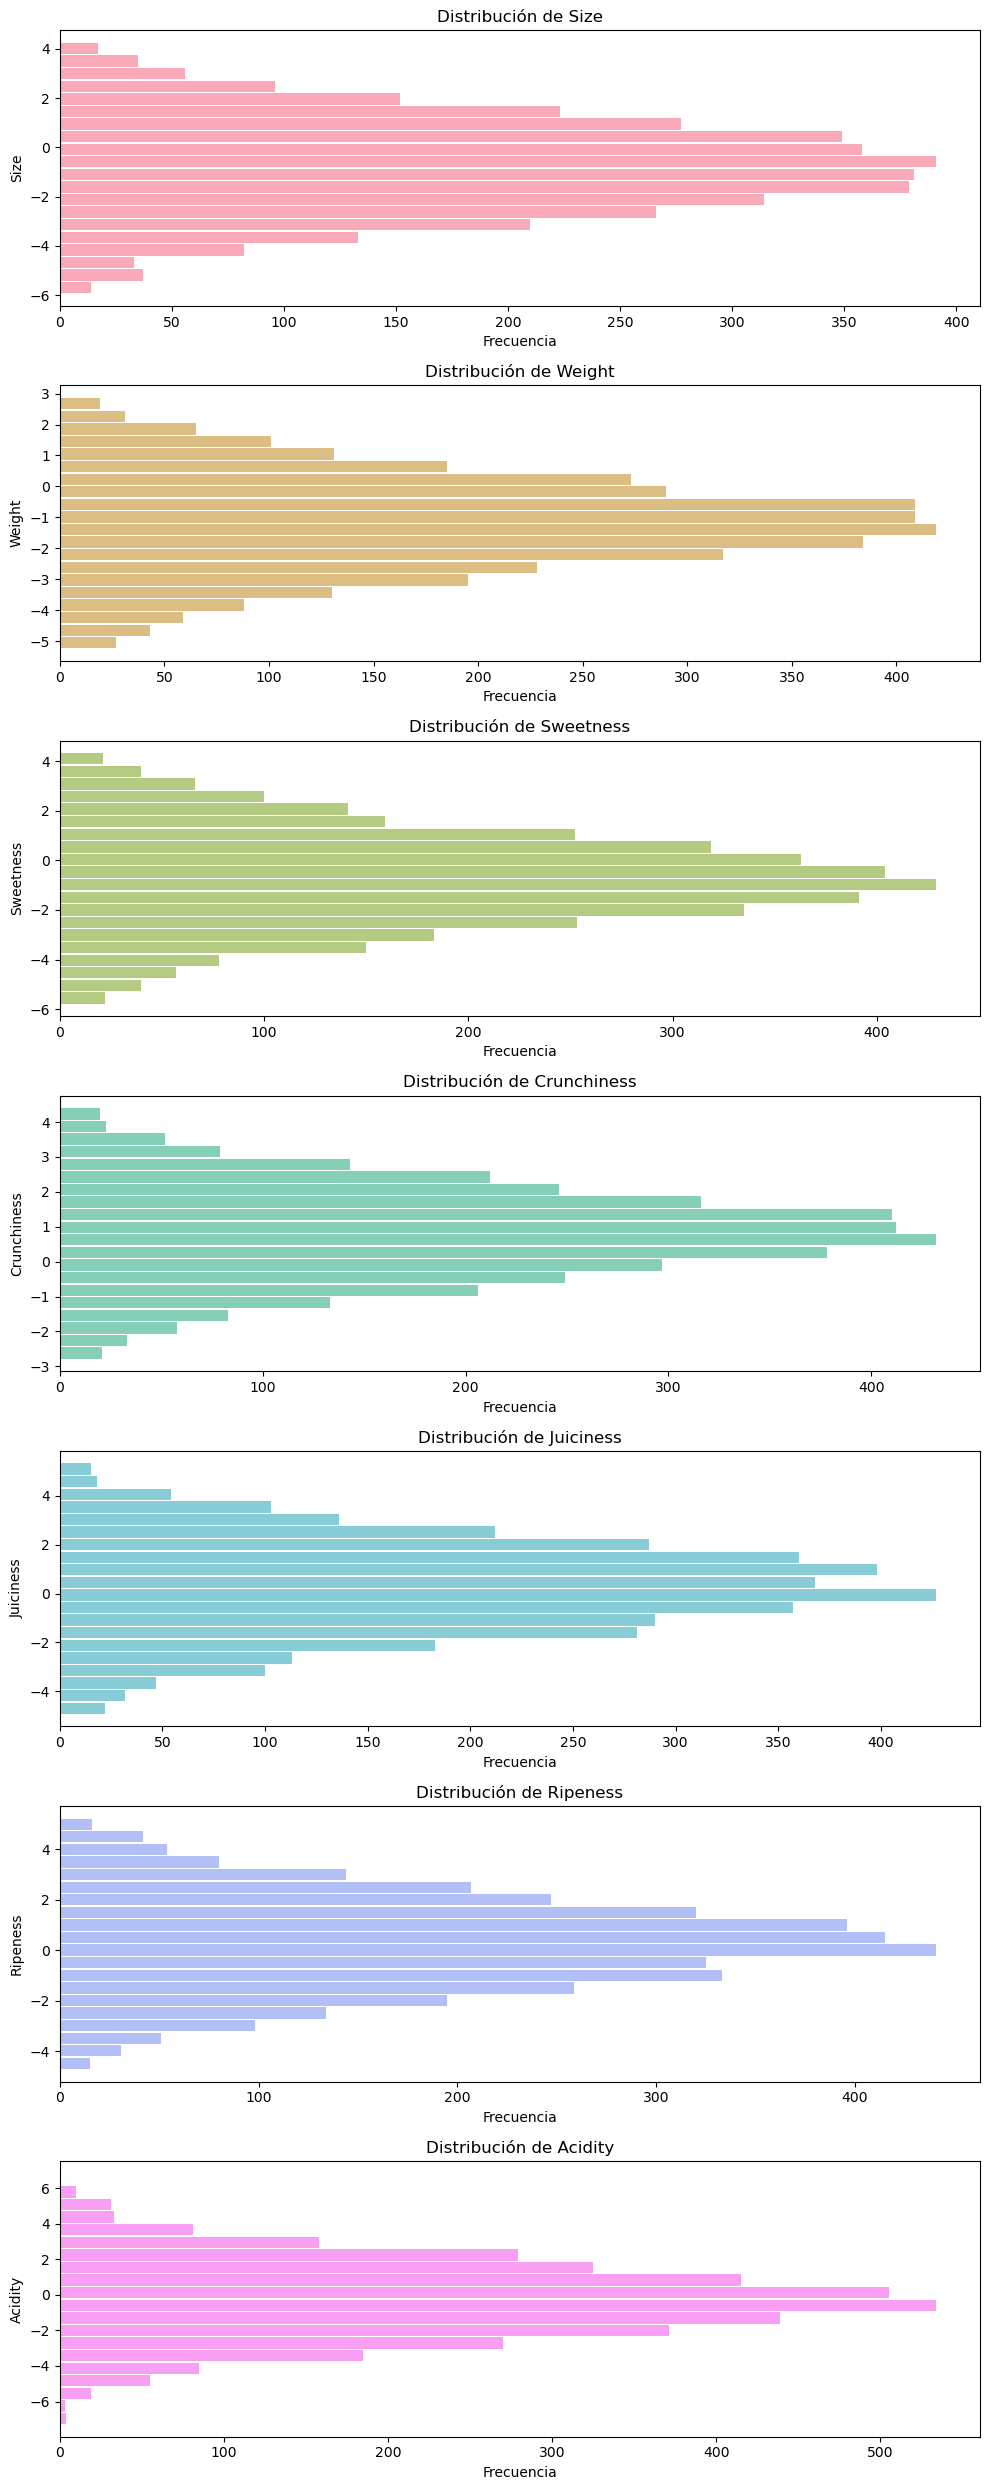

In [24]:
# Configuración del tamaño de la figura para una disposición vertical de gráficos horizontales
fig, ax = plt.subplots(nrows=len(vcontinuas), ncols=1, figsize=(10, 25))  # Aumentamos la altura para múltiples gráficos

# Paleta de colores para los gráficos
colors = sns.color_palette("husl", len(vcontinuas))  # Paleta "husl" para variedad de colores

# Crear un histograma horizontal para cada variable continua
for i, (var, color) in enumerate(zip(vcontinuas, colors)):
    # Generar el histograma y sus frecuencias con bins (intervalos) para datos continuos
    counts, bin_edges = np.histogram(df[var], bins=20)
    
    # Crear el gráfico de barras horizontales con espacio entre las barras
    ax[i].barh(y=bin_edges[:-1], width=counts, height=(bin_edges[1] - bin_edges[0]) * 0.9, color=color, alpha=0.6)
    ax[i].set_title(f'Distribución de {var}')
    ax[i].set_xlabel('Frecuencia')
    ax[i].set_ylabel(var)

plt.tight_layout()
plt.show()

Estos gráficos verticales dan otro punto de vista a la distribución de los datos, confirmando la distribuión normal que habíamos comentado con anterioridad.

#### Boxplots:

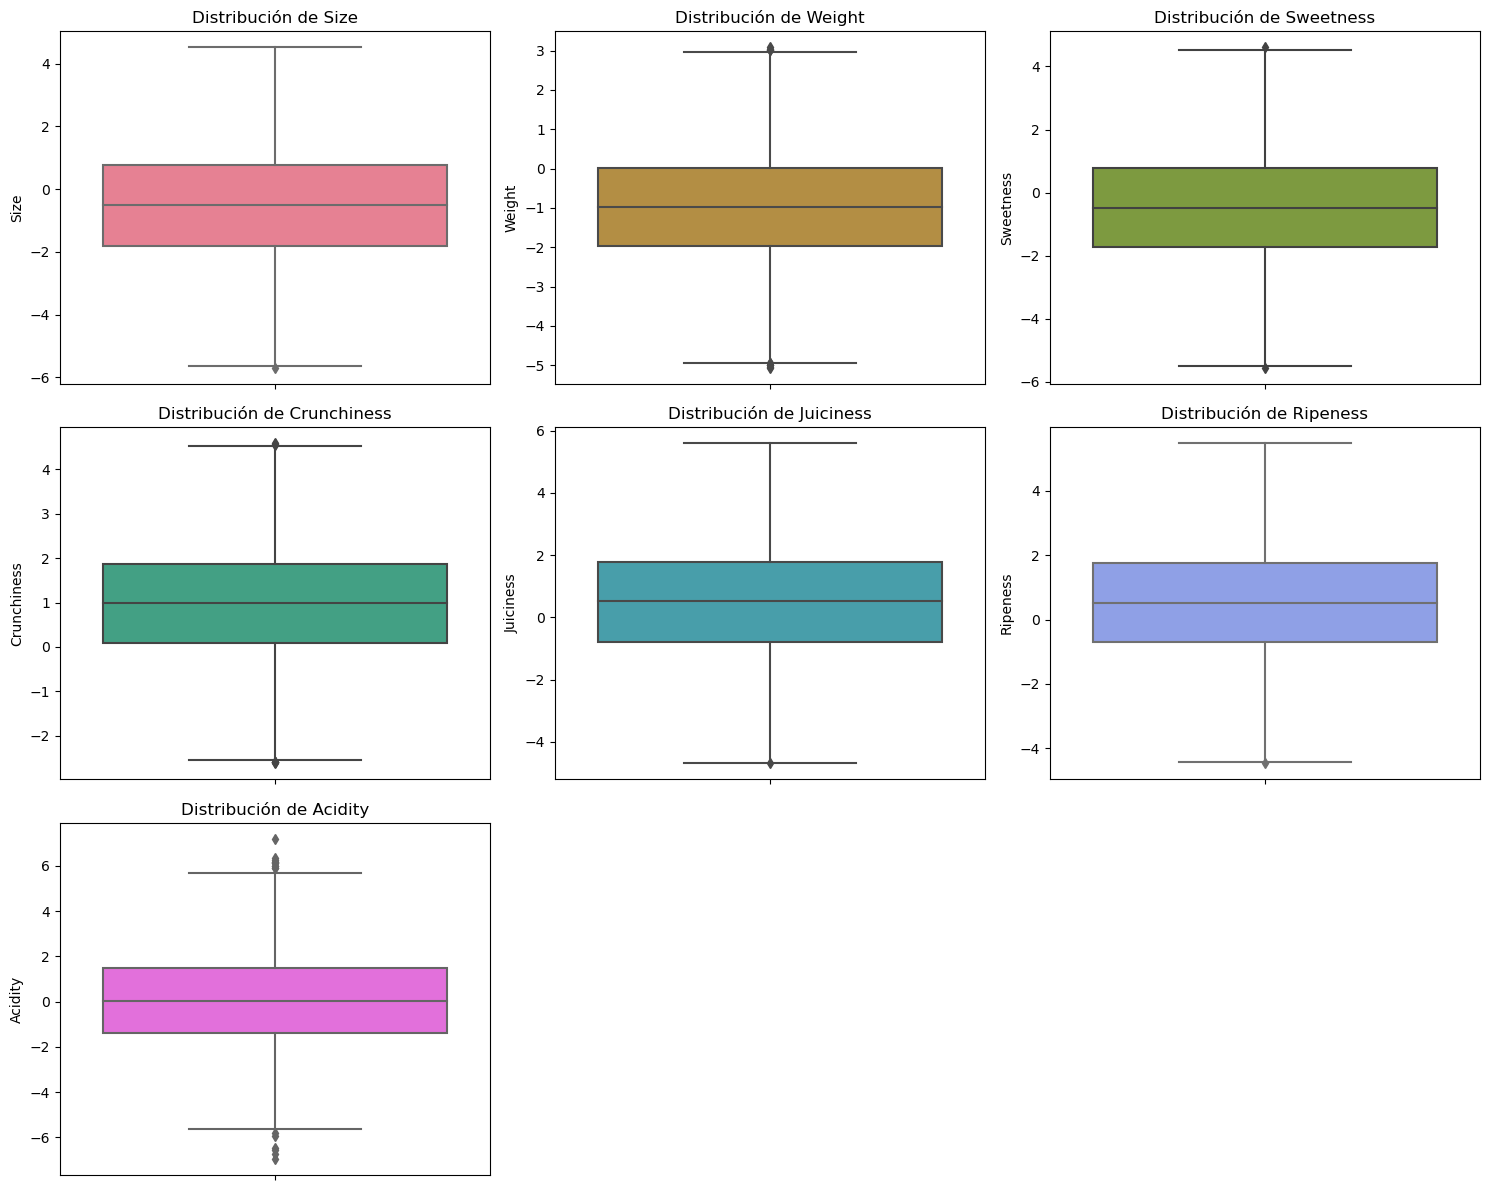

In [25]:
# Determinar la cuadrícula adecuada en función del número de variables
n_vars = len(vcontinuas)
n_cols = 3  # Puedes ajustar este valor para cambiar el número de columnas
n_rows = math.ceil(n_vars / n_cols)

# Configuración del tamaño del gráfico y organización en cuadrícula
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, n_rows * 4))

# Aplanar la cuadrícula de ejes para iterar fácilmente
axes = axes.flatten()

# Paleta de colores para asegurar que hay suficientes colores
colors = sns.color_palette("husl", n_vars)

# Crear un boxplot para cada variable en su propio subplot
for i, (var, color) in enumerate(zip(vcontinuas, colors)):
    sns.boxplot(y=df[var], ax=axes[i], color=color)
    axes[i].set_title(f'Distribución de {var}')
    axes[i].set_ylabel(var)

# Remover los ejes restantes si hay menos variables que subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

La visualización de los boxplots muestra que la mayoría de las variables (Size, Weight, Sweetness, Crunchiness, Juiciness, Ripeness) presentan distribuciones simétricas alrededor de la mediana, con rangos intercuartílicos amplios que indican una variabilidad moderada entre los datos. Estas distribuciones simétricas sugieren que las variables están bien distribuidas sin sesgos extremos, lo cual es favorable para el análisis, ya que permite una interpretación consistente de sus valores centrales.

La variable Acidity, sin embargo, muestra algunos valores extremos que se encuentran fuera del rango intercuartílico, lo cual destaca que esta variable tiene mayor variabilidad en comparación con las demás. Estos valores atípicos indican que existen casos de acidez elevada en algunas observaciones, lo cual podría influir en ciertos análisis o modelos sensibles a valores extremos. En general, esta visualización confirma que las variables mantienen una buena dispersión y balance alrededor de sus medianas, salvo en el caso de Acidity, que presenta una mayor amplitud en sus datos extremos.

#### Ahora usamos boxplots en relación a la variable objetivo:

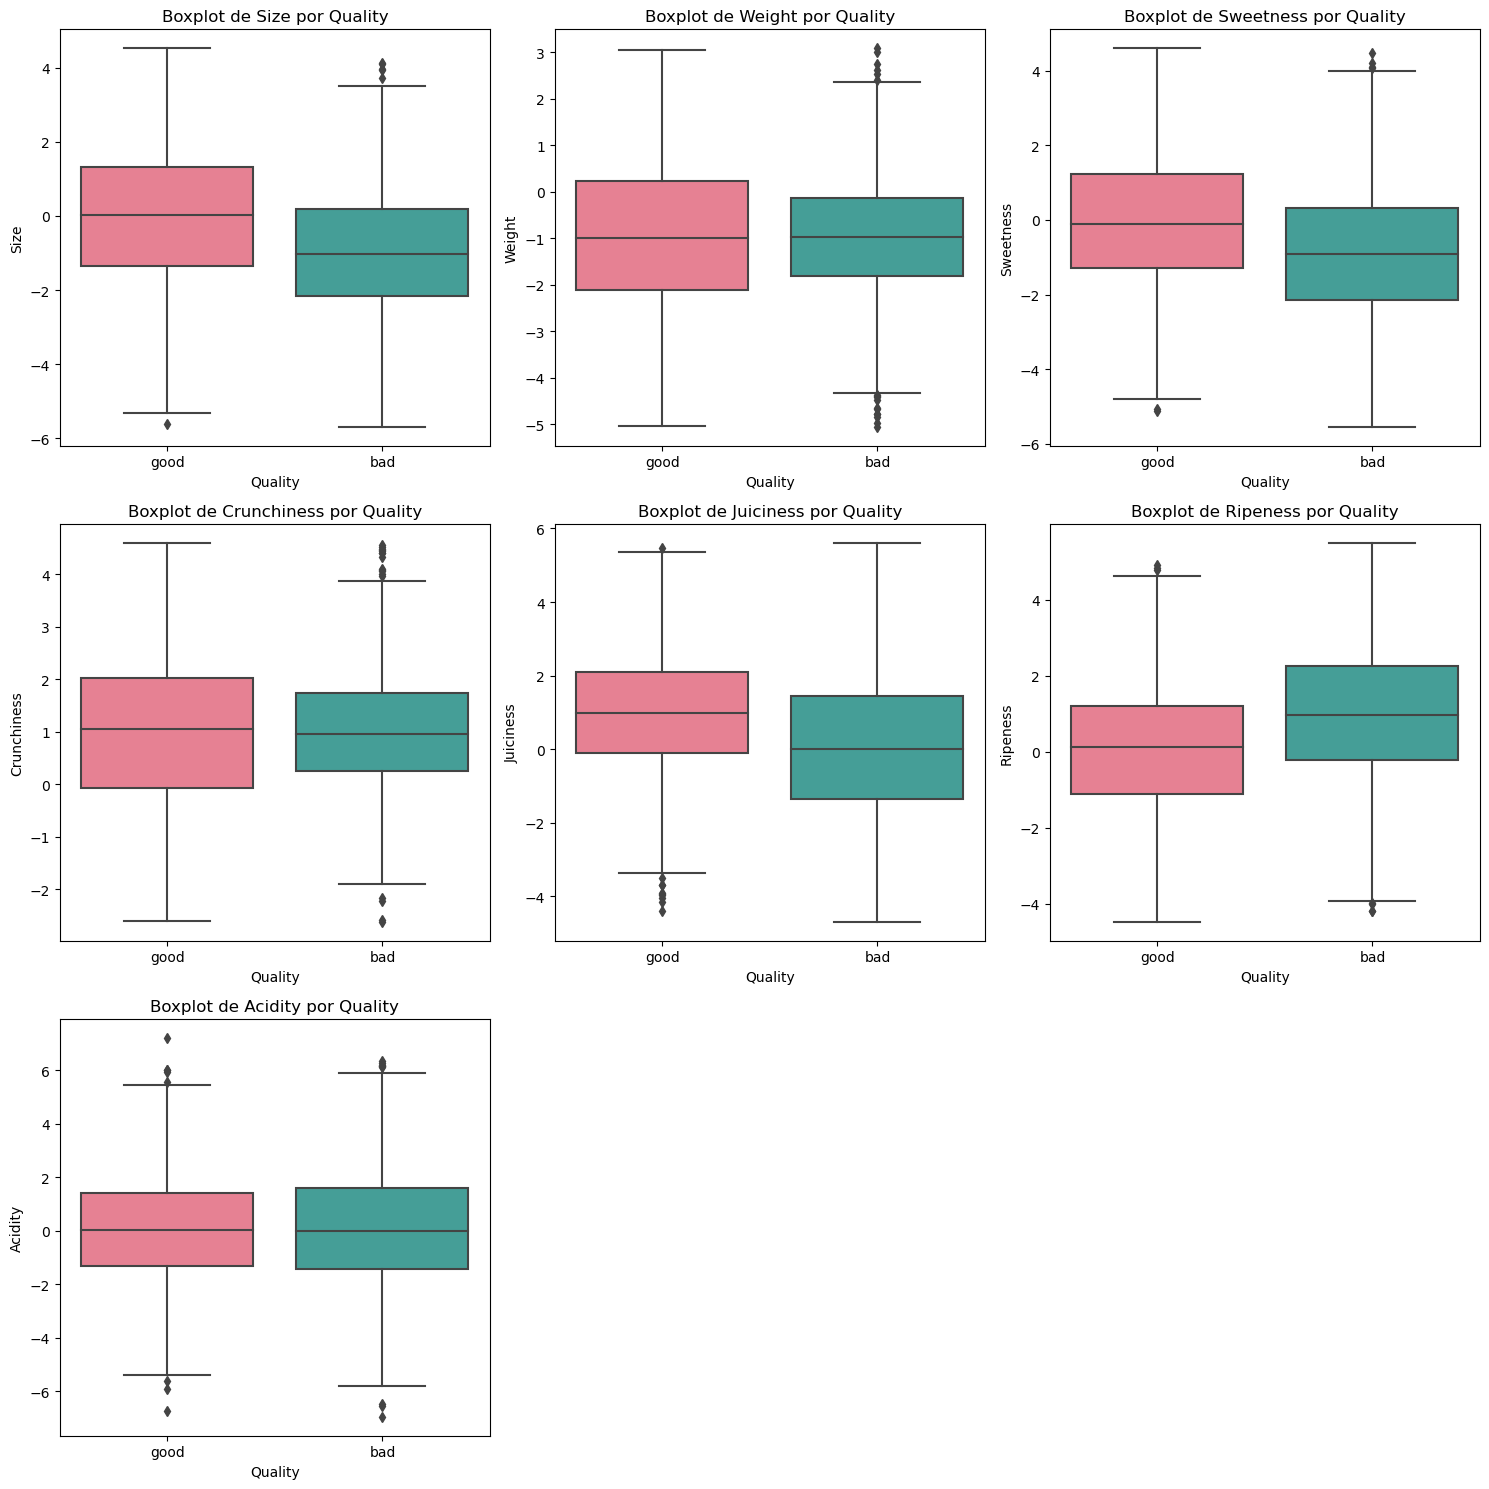

In [26]:
# Configuración del tamaño de la figura para los boxplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))

# Lista de variables continuas sin 'Quality'
vcontinuas = df.drop(columns='Quality').columns

# Aplanar los ejes para iterar fácilmente
axes = axes.flatten()

# Crear un boxplot segmentado por Quality para cada variable continua
for i, var in enumerate(vcontinuas):
    sns.boxplot(x='Quality', y=var, data=df, ax=axes[i], palette="husl")
    axes[i].set_title(f'Boxplot de {var} por Quality')
    axes[i].set_xlabel('Quality')
    axes[i].set_ylabel(var)

# Remover ejes sobrantes si hay menos variables que subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

En los boxplots de las variables continuas segmentadas por Quality (con categorías good y bad), podemos observar algunas diferencias en las distribuciones de las variables en función de esta variable dependiente. La mayoría de las variables presentan medianas ligeramente diferentes entre las categorías good y bad, aunque las diferencias no son muy marcadas. Esto sugiere que, aunque hay cierta variación en el valor central de estas variables según la calidad (Quality), no es lo suficientemente significativa como para indicar una clara separación entre las dos categorías en estas variables.

Particularmente, en Ripeness y Acidity, los boxplots muestran una leve tendencia: los valores de Ripeness y Acidity tienden a ser un poco más altos en la categoría bad que en good. Esto podría indicar que las frutas de menor calidad tienen una mayor madurez y acidez, aunque la diferencia no es muy pronunciada. Los rangos intercuartílicos y la dispersión de los datos son similares en ambas categorías, sugiriendo que la variabilidad de cada variable es comparable entre las dos clases de Quality.

En general, los boxplots sugieren que las variables explicativas tienen un impacto moderado en la clasificación de Quality. No se observan grandes diferencias en la mayoría de las variables entre las categorías good y bad, lo cual indica que estas características pueden no ser completamente determinantes por sí solas para distinguir la calidad, aunque podrían contribuir al modelo en conjunto para capturar ciertas tendencias leves.

#### Mostramos la frecuencia de nuestra variable objetivo:

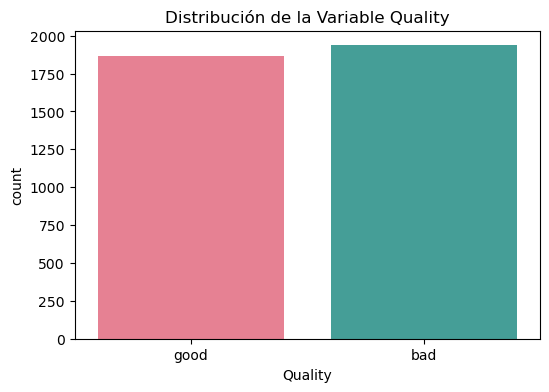

In [27]:
# Conteo de observaciones por categoría de Quality
plt.figure(figsize=(6, 4))
sns.countplot(x='Quality', data=df, palette="husl")
plt.title('Distribución de la Variable Quality')
plt.show()

Ambas categorías de nuestra variable objetivo es bastante similar, así que muestra un equilibrio en la cantidad de registros para cada una de ellas.

#### 2. Divida los datos en 70% para entrenamiento y 30% para test, luego entrene tres modelos SVM cada uno con diferente función de kernel: linear, rbf y poly, variando para cada uno de ellos el valor de C para siete valores diferentes que deben ir desde 0.001 hasta 0.02. Determine cual de todos los modelos genera el mejor accuracy. (5 pts.)

#### Usamos get.dummies en nuestra variable objetivo:

In [28]:
df = pd.get_dummies(data=df, columns=['Quality'], drop_first=True, dtype='int')
df.head()

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality_good
0,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809,1
1,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636,0
2,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723,1
3,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984,1
4,-3.425400,-1.409082,-1.913511,-0.555775,-3.853071,1.914616,-2.981523,0


#### Dividimos los datos en 70% para entrenamiento y 30% para test

In [29]:
# Definir variables predictoras (X) y variable objetivo (y)
X = df.drop('Quality_good', axis=1)
y = df['Quality_good']

# Dividir los datos en 70% para entrenamiento y 30% para test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

#### Entrenamos los distintos modelos según el requerimiento

In [30]:
# Definir los valores de C
C_values = [0.001, 0.004, 0.007, 0.01, 0.013, 0.016, 0.02]

# Lista para almacenar los resultados
results = []

# Entrenar el modelo con diferentes kernels y valores de C
for kernel in ['linear', 'rbf', 'poly']:
    for C in C_values:
        # Definir el modelo con el kernel y el valor de C especificado
        model = SVC(kernel=kernel, C=C, random_state=10)
        
        # Entrenar el modelo
        model.fit(X_train, y_train)
        
        # Predecir en el conjunto de prueba
        y_pred = model.predict(X_test)
        
        # Calcular el accuracy
        accuracy = accuracy_score(y_test, y_pred)
        
        # Guardar los resultados
        results.append((kernel, C, accuracy))

# Convertir los resultados a un DataFrame y ordenar por accuracy de mayor a menor
results_df = pd.DataFrame(results, columns=['Kernel', 'C', 'Accuracy'])
results_df = results_df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

# Mostrar todos los resultados ordenados de mayor a menor accuracy
print("Resultados de accuracy para cada modelo (ordenados de mayor a menor):")
print(results_df)

# Obtener el máximo accuracy
max_accuracy = results_df['Accuracy'].max()

# Filtrar todos los modelos que tienen el máximo accuracy
best_models = results_df[results_df['Accuracy'] == max_accuracy]

# Mostrar los mejores modelos
print("\nMejores modelos con el máximo accuracy:")
print(best_models)

Resultados de accuracy para cada modelo (ordenados de mayor a menor):
    Kernel      C  Accuracy
0     poly  0.007  0.794040
1      rbf  0.020  0.794040
2     poly  0.020  0.791411
3     poly  0.016  0.791411
4     poly  0.013  0.789658
5      rbf  0.016  0.789658
6     poly  0.010  0.788782
7     poly  0.004  0.779141
8      rbf  0.013  0.778265
9      rbf  0.010  0.770377
10     rbf  0.007  0.756354
11  linear  0.007  0.736196
12  linear  0.020  0.735320
13  linear  0.016  0.734443
14  linear  0.013  0.734443
15  linear  0.010  0.734443
16  linear  0.004  0.731814
17  linear  0.001  0.722174
18     rbf  0.004  0.491674
19    poly  0.001  0.490798
20     rbf  0.001  0.489921

Mejores modelos con el máximo accuracy:
  Kernel      C  Accuracy
0   poly  0.007   0.79404
1    rbf  0.020   0.79404


El análisis de los modelos entrenados con distintos kernels y valores de C muestra que los mejores desempeños (con un accuracy de aproximadamente 0,794) se lograron con el kernel poly y C=0,007 y el kernel rbf con C=0,020. Esto sugiere que ambos kernels (polinomial y radial) pueden capturar patrones en los datos de manera efectiva, aunque sus resultados no difieren en términos de precisión.

La observación de que dos configuraciones distintas de kernel alcanzan el mismo accuracy máximo sugiere que la elección del kernel en este caso tiene un efecto moderado, y que tanto la complejidad polinomial como las transformaciones no lineales de rbf son capaces de modelar la relación entre las variables explicativas y la variable objetivo con éxito similar.

Por otro lado, los modelos con el kernel linear presentaron en general un accuracy menor, lo que indica que la relación entre las variables explicativas y la variable de calidad (Quality) no es lineal y se beneficia de kernels que introducen no linealidades en el modelo. En conclusión, para este conjunto de datos, los kernels poly y rbf son preferibles, siendo ambos adecuados para capturar la estructura de los datos.

#### 3a. Entrene un modelo de regresión lineal para predecir el nivel de dulzor de la manzana (Sweetness) usando como variables regresoras las otras características sin considerar la variable de Quality.

In [31]:
# Definir variables predictoras (X) excluyendo 'Sweetness' y 'Quality'
X = df.drop(columns=['Sweetness', 'Quality_good'])
# Definir la variable objetivo (y) como 'Sweetness'
y = df['Sweetness']

# Dividir los datos en entrenamiento (70%) y prueba (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

# Crear y entrenar el modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

print("Modelo de regresión lineal entrenado para predecir Sweetness.")

Modelo de regresión lineal entrenado para predecir Sweetness.


#### Prueba con una fila creada artificalmente

In [37]:
# Creamos una fila fictisia
new_obs = pd.DataFrame({
    'Size': [0.8],
    'Weight': [-1.3],
    'Crunchiness': [1.1],
    'Juiciness': [1],
    'Ripeness': [-1.5],
    'Acidity': [1.2]
})

new_obs

,Size,Weight,Crunchiness,Juiciness,Ripeness,Acidity
0,0.8,-1.3,1.1,1,-1.5,1.2


#### Hacemos la prueba:

In [39]:
# Utilizar el modelo entrenado para hacer predicciones en la nueva observación
y_pred_new = model.predict(new_obs)

# Mostrar la predicción
y_pred_new

array([0.00182542])

#### ¿Está dentro de los valores probables?

In [41]:
df.describe()

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality_good
count,3803.000000,3803.000000,3803.000000,3803.000000,3803.000000,3803.000000,3803.000000,3803.000000
mean,-0.512107,-0.987696,-0.477286,0.983250,0.501966,0.527346,0.067108,0.490928
std,1.855284,1.499626,1.872601,1.299762,1.852821,1.805351,2.084345,0.499983
min,-5.692093,-5.058679,-5.548641,-2.620954,-4.688478,-4.471210,-6.955460,0.000000
25%,-1.800751,-1.970026,-1.724301,0.093946,-0.792918,-0.712315,-1.373326,0.000000
50%,-0.517699,-0.979619,-0.503052,0.994175,0.514115,0.526588,0.017096,0.000000
75%,0.771448,0.010163,0.783380,1.872825,1.792787,1.771178,1.484951,1.000000
max,4.524772,3.081538,4.606386,4.591936,5.598023,5.484760,7.193374,1.000000


Nuestra fila fictisia efectivamente se encuentra dentro del rango probable.

#### 3b.- Analice los residuos del modelo entrenado usando los datos de entrenamiento y verifique que distribuyan de acuerdo a la distribución normal con media cero y que su variabilidad sea homocedastica. Para esto se sugiere graficar los valores ajustados con sus residuos. (8 pts.)

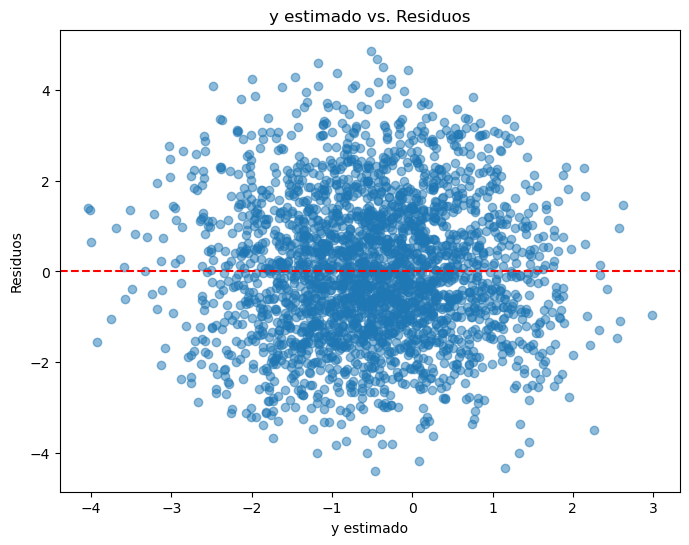

In [43]:
# Predecir en el conjunto de entrenamiento
y_train_pred = model.predict(X_train)

# Calcular los residuos
residuals = y_train - y_train_pred

# Paso 2: Graficar Valores Ajustados vs. Residuos para verificar homocedasticidad
plt.figure(figsize=(8, 6))
plt.scatter(y_train_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("y estimado")
plt.ylabel("Residuos")
plt.title("y estimado vs. Residuos")
plt.show()

El gráfico de y estimado vs. Residuos muestra que los residuos están dispersos de manera bastante uniforme alrededor de la línea horizontal en cero, sin patrones claros o formas específicas. Esta dispersión aleatoria sugiere que el modelo cumple con la suposición de homocedasticidad, es decir, la variabilidad de los residuos es constante a lo largo de todos los valores de y estimado. La ausencia de patrones también indica que el modelo de regresión lineal está capturando adecuadamente la relación entre las variables, sin evidencia de una estructura no capturada en los datos. Esto respalda la validez del modelo en términos de la suposición de homocedasticidad.

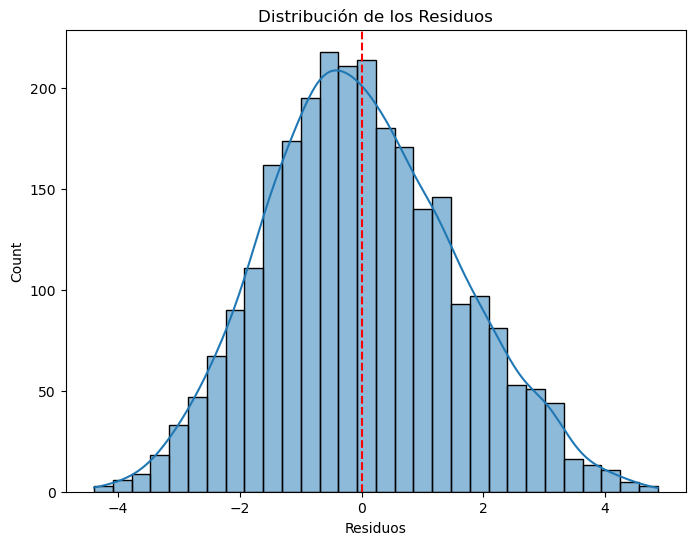

In [44]:
# Paso 3a: Histograma de los residuos para verificar la normalidad
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.axvline(x=0, color='red', linestyle='--')
plt.xlabel("Residuos")
plt.title("Distribución de los Residuos")
plt.show()

Este histograma de los residuos muestra que la distribución de los residuos tiene una forma simétrica y centrada alrededor de cero, lo cual es un buen indicio de que los residuos siguen una distribución normal. La curva de densidad superpuesta refuerza esta observación, ya que tiene una forma de campana, típica de una distribución normal.

La línea roja vertical en cero indica el centro de la distribución, y la simetría de los residuos a ambos lados de esta línea sugiere que el modelo no tiene un sesgo sistemático y que los errores de predicción están equilibrados alrededor de cero.

Este patrón es positivo, ya que uno de los supuestos clave de la regresión lineal es que los residuos tengan una distribución normal con media cero. Esto sugiere que el modelo es adecuado para los datos y respalda la validez de las inferencias y predicciones hechas por el modelo de regresión lineal.

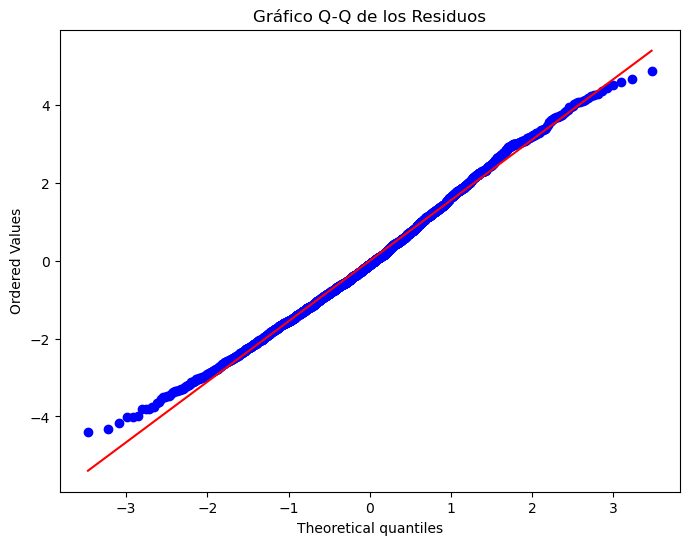

In [45]:
# Paso 3b: Gráfico Q-Q para verificar normalidad de los residuos
plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Gráfico Q-Q de los Residuos")
plt.show()

En este gráfico, observamos que los puntos están muy cerca de la línea diagonal en casi toda la extensión del gráfico, lo cual sugiere que los residuos se aproximan a una distribución normal. Solo en los extremos (valores más alejados del centro) hay algunos puntos que se desvían ligeramente de la línea, lo cual es común y generalmente aceptable en análisis de regresión.

En resumen, este gráfico Q-Q respalda la suposición de normalidad de los residuos, indicando que el modelo es adecuado en este aspecto. La normalidad de los residuos es una condición favorable para la validez de inferencias y predicciones en un modelo de regresión lineal, ya que asegura que los errores se distribuyen de manera simétrica alrededor de cero sin sesgos significativos.

#### 4. Realice una evaluación del modelo de regresión lineal usando una métrica adecuada he interprete el efecto de las variables regresoras en la variable dependiente. Describa si el modelo es aceptable o no y cómo podemos mejorarlo.

#### Evaluamos el modelo

In [46]:
# Realizar predicciones en el conjunto de prueba
y_test_pred = model.predict(X_test)

# Calcular R²
r2 = r2_score(y_test, y_test_pred)

# Calcular MAE
mae = mean_absolute_error(y_test, y_test_pred)

# Calcular MSE
mse = mean_squared_error(y_test, y_test_pred)

# Calcular RMSE (Raíz del MSE)
rmse = np.sqrt(mse)

# Calcular RSE (Residual Standard Error)
# Ajuste de grados de libertad: n - p - 1
n = len(y_test)          # Número de observaciones en el conjunto de prueba
p = X_train.shape[1]      # Número de variables predictoras
rse = np.sqrt(mse * (n / (n - p - 1)))

# Imprimir todas las métricas
print("Evaluación del modelo de regresión lineal:")
print(f"R²: {r2:.4f}")
print(f"MAE (Error Medio Absoluto): {mae:.4f}")
print(f"MSE (Error Cuadrático Medio): {mse:.4f}")
print(f"RMSE (Raíz del Error Cuadrático Medio): {rmse:.4f}")
print(f"RSE (Error Estándar de los Residuos): {rse:.4f}")

Evaluación del modelo de regresión lineal:
R²: 0.3198
MAE (Error Medio Absoluto): 1.2162
MSE (Error Cuadrático Medio): 2.3615
RMSE (Raíz del Error Cuadrático Medio): 1.5367
RSE (Error Estándar de los Residuos): 1.5415


El modelo de regresión lineal muestra un R² de 0,32, lo que indica que solo una pequeña parte de la variabilidad en Sweetness es explicada por las variables regresoras. Esto sugiere que la relación entre Sweetness y las otras características no es totalmente capturada por este modelo lineal, lo que limita su precisión predictiva.

En cuanto a las otras métricas, el MAE de 1,2 indica que, en promedio, el modelo comete un error de 1,2 unidades al predecir Sweetness, mientras que el RMSE de 1,5 muestra una magnitud similar de error, penalizando levemente más los errores grandes. El RSE de 1,54, que es muy cercano al RMSE, refuerza que los errores se distribuyen de forma consistente en el rango de valores predichos.

En cuanto al efecto de las variables regresoras en Sweetness, los coeficientes del modelo permiten identificar si cada variable tiene una relación positiva o negativa con Sweetness (las veremos en el próximo paso). Por ejemplo, un coeficiente positivo sugiere que un aumento en esa variable predice un aumento en el nivel de dulzor. Sin embargo, el bajo valor de R² y los errores relativamente altos (MAE y RMSE) sugieren que estas relaciones lineales son débiles y posiblemente insuficientes para describir completamente el comportamiento de Sweetness en función de las variables disponibles.

#### Mostramos coeficientes para analizar la relación de las variables independientes con la variable dependiente

In [47]:
# Crear un DataFrame para mostrar los coeficientes del modelo de regresión lineal
coef_df = pd.DataFrame({
    "Variable": X.columns,
    "Coeficiente": model.coef_
})

print("Coeficientes del modelo de regresión lineal:")
coef_df

Coeficientes del modelo de regresión lineal:


,Variable,Coeficiente
0,Size,-0.454250
1,Weight,-0.390122
2,Crunchiness,-0.108433
3,Juiciness,-0.041648
4,Ripeness,-0.441547
5,Acidity,0.087923


La mayoría de las variables tienen coeficientes negativos, lo que indica que aumentos en estas características (Size, Weight, Crunchiness, Juiciness, y Ripeness) están asociados con una reducción en Sweetness.

El único coeficiente positivo es el de Acidity, lo que sugiere una relación positiva leve con Sweetness.

Estos coeficientes representan las relaciones promedio de cada variable con el dulzor, pero el bajo valor de R² sugiere que estas relaciones son débiles o que el modelo lineal no está capturando adecuadamente la relación entre las variables predictoras y Sweetness.

#### Conclusión y Propuestas de Mejora

El modelo actual es aceptable como un primer intento para explorar la relación entre Sweetness y las variables predictoras, pero no es ideal para hacer predicciones precisas debido a su bajo poder explicativo. Para mejorar el modelo, se pueden considerar los siguientes enfoques:

**Explorar Modelos No Lineales:** Dado que la relación entre Sweetness y las otras variables podría ser más compleja, modelos no lineales (como regresión polinomial, Random Forest o Gradient Boosting) podrían capturar patrones que el modelo lineal no detecta.

**Agregar Nuevas Variables:** Es posible que algunas características importantes para predecir el dulzor de las manzanas no estén incluidas en los datos actuales. Añadir variables adicionales relevantes podría mejorar la capacidad explicativa del modelo. Por ejemplo incluir variables como especie de manzana, lugar de cultivo, tipo de agua con el que se riega, diferencias de temperaturas entre el día y la noche y condiciones climáticas.

**Revisar la Relevancia de las Variables Existentes:** Si algunos coeficientes son muy cercanos a cero, esas variables pueden no estar aportando mucho al modelo y podrían eliminarse para simplificarlo.

En resumen, el modelo de regresión lineal tiene un rendimiento limitado en este caso. Mejorarlo requerirá explorar modelos más complejos y considerar otras variables que puedan influir en Sweetness.